<a href="https://colab.research.google.com/github/Camouflage10/RL-stocks/blob/main/RLStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
!pip install yfinance
import yfinance as yf
import tensorflow as tf
import datetime
import math
import random
#global
n=60
lookAhead=24

1. set up game given 60 values guess buy or sell
2. graphing each step and wait for answer
3. setup a NN that catagorizes the state
4. setup RL model with the NN output plugiung in the states
5. optimize models

In [ ]:
def getData(code, period, interval):
  df=yf.download(code,period=period,interval=interval)
  return df
data=getData("AAPL",'3mo','1h')
#normalize data between min max
data.head

[*********************100%***********************]  1 of 1 completed


<bound method NDFrame.head of                                  Open        High         Low       Close  \
2022-01-31 09:30:00-05:00  170.160004  173.619995  169.509995  172.619995   
2022-01-31 10:30:00-05:00  172.610001  173.360001  172.270004  172.570007   
2022-01-31 11:30:00-05:00  172.565002  173.580002  172.350006  172.634995   
2022-01-31 12:30:00-05:00  172.630005  173.087402  172.429993  173.029999   
2022-01-31 13:30:00-05:00  173.035004  173.740005  172.800003  173.619995   
...                               ...         ...         ...         ...   
2022-04-29 12:30:00-04:00  160.389999  160.720001  159.589996  160.100006   
2022-04-29 13:30:00-04:00  160.104996  160.729904  159.600006  159.970001   
2022-04-29 14:30:00-04:00  159.960007  160.164993  158.710007  158.750000   
2022-04-29 15:30:00-04:00  158.740005  159.225006  157.250000  157.649994   
2022-04-29 16:00:00-04:00  157.649994  157.649994  157.649994  157.649994   

                            Adj Close    Volu

#1.linear reg the next n values and in the y=mx+b the m will be the state
#2. research different shapes and the states are defined as those shapes


In [ ]:
def squeezeData(batch):#gets batch between 0-1
  min=np.amin(batch)
  max=np.amax(batch)
  for j in range(len(batch)):#scale from 0-1
    batch[j] = (batch[j]-min)/(max-min)
  return batch

In [ ]:
#linear reg stateData
from sklearn.linear_model import LinearRegression
def regLookAhead(stateData,lookAhead):#takes in lookAhead number and data and outs a linear model
  x=np.array([i for i in range(lookAhead)]).reshape(-1,1)
  labely=stateData
  #add hyper param
  reg = LinearRegression()
  reg.fit(x, labely)
  #reg.coef_
  return reg

In [ ]:
def giveState(reg):
  x=reg.coef*3+6
  if x<0:
    return 0
  if x>12:
    return 12
  return int(x)

In [ ]:
def preprocessing(df,n,lookAhead):
  df=df.filter(['Adj Close'])
  df=df.values
  X=[]
  y=[]
  stateData=[]
  for i in range(n,len(df)-(n+lookAhead)):
    preBatch=df[i-n:i,0]
    batch=preBatch.copy()
    batch=squeezeData(batch)
    X.append(batch)#first n val scaled
    stateData=df[i:i+lookAhead,0]#next lookAhead values
    reg=regLookAhead(stateData,lookAhead)
    #append state or coef and %diff of last val and y intercept
    state=[reg.coef_]
    y.append(state)
  return X,y

In [ ]:
def multiPreprocessing(df,n,lookAhead):
  X=[]
  y=[]
  for d in df:
    d=d.filter(['Adj Close'])
    d=d.values
    stateData=[]
    for i in range(n,len(d)-(n+lookAhead)):
      preBatch=d[i-n:i,0]
      batch=preBatch.copy()
      batch=squeezeData(batch)
      X.append(batch)#first n val scaled
      stateData=d[i:i+lookAhead,0]#next lookAhead values
      reg=regLookAhead(stateData,lookAhead)
      #append state or coef and %diff of last val and y intercept
      state=[reg.coef_]
      y.append(state)
  return X,y

In [ ]:
data=getData('AAPL','1y','1h')
df=[]
stocks=['AAPL','TSLA']
for stock in stocks:
  df.append(getData(stock,'1y','1h'))
X,y=preprocessing(data,n,lookAhead)
batch=X[0]
testy=y[0]
print(batch)
print(testy)
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)
print(len(X_train))
print(len(y_train))
X_trainS=tf.stack(X_train)
y_trainS=tf.stack(y_train)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[0.95004511 0.93460476 0.93278923 0.8585838  0.82016379 0.80381428
 0.78928309 1.         0.86058089 0.88324318 0.85558609 0.90236172
 0.8909987  0.88340672 0.49682143 0.42870151 0.41825595 0.38370607
 0.39677583 0.40826497 0.46412381 0.59598559 0.62489554 0.63855639
 0.59503209 0.55177112 0.47682977 0.48319661 0.45413283 0.5122701
 0.57311541 0.53678534 0.5175296  0.57219795 0.62670276 0.70493146
 0.74801088 0.71700268 0.66484975 0.67393296 0.69346034 0.66939135
 0.50454091 0.49818377 0.50590326 0.49395954 0.39682088 0.39600389
 0.36603095 0.05722049 0.20345132 0.23024499 0.26792909 0.30791101
 0.28474079 0.27429593 0.06539524 0.0308807  0.         0.00329706]
[array([0.11865252])]
1137
1137


In [ ]:
#3 have it auto label data
#study the data and define states
#normalize data between min max of the batch 0 1
#import karas
#get batch-60 of data
#label the data with the state that we want to predict
#7,5, or increase-linereg
#10-20 states for -shaperecog
# input 60 compare 1-3 hidden layers, output #states values between 0-1, play with different activation fuctions
!pip install -q -U keras-tuner
import keras_tuner as kt
#start nodes, array of ints for lstm, array of ints for dense, act, dropout
def lstmModel(inputShape=(len(X_train[0]),1),start=60,rate=.5,layers=3, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  nodes=start*rate
  #input
  model.add(LSTM(120, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(start,return_sequences=False))
  model.add(Dense(nodes,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

In [ ]:
def lstmModel2(inputShape=(len(X_train[0]),1),start=120,next=60,last=20, act=None, dropout=0.0,reg='l2'):#add parameters of start nodes, radio to next layer and #of hidden layers
  model=Sequential()
  #input
  model.add(LSTM(start, return_sequences=True, input_shape=inputShape))#change hyperparameters but pick an independant variable 
  #hidden layer
  model.add(LSTM(next,return_sequences=False))
  model.add(Dropout(dropout))
  model.add(Dense(last,activation=act, kernel_regularizer=reg))
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')#change optimizer customize loss to take abs of the difference
  return model

In [ ]:
from keras.backend import dropout
#gridsearch hyper parameters
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
mod = KerasClassifier(build_fn=lstmModel2)
param=dict(dropout=[None,.05,.08,.1], epochs=[10,20], start=[400,200,150],next=[200,100],last=[200,100])
grid = GridSearchCV(estimator=mod, param_grid=param, n_jobs=-1, scoring='neg_root_mean_squared_error', cv=3, refit=False)
grid_result = grid.fit(X_train, y_train)
print(grid_result.best_params_)
#{'dropout': 0.2, 'epochs': 50, 'layers': 2, 'rate': 0.1, 'start': 60}
#{'dropout': 0.1, 'epochs': 25, 'layers': 1, 'rate': 0.075, 'start': 50}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """


{'dropout': None, 'epochs': 10, 'last': 200, 'next': 200, 'start': 400}


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
288 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
288 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/keras/wrappers/scikit_learn.py", line 234, in fit
    raise ValueError('Invalid shape for y: ' + str(y.shape))
ValueError: Invalid shape for y: (758, 1, 1)

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/mode

In [ ]:
#make models
models=[]
models.append(lstmModel((len(X_train[0]),1),80,.5,4,dropout=.5))
models.append(lstmModel2())
for model in models:
  model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_47 (LSTM)              (None, 60, 120)           58560     
                                                                 
 lstm_48 (LSTM)              (None, 80)                64320     
                                                                 
 dense_77 (Dense)            (None, 40)                3240      
                                                                 
 dense_78 (Dense)            (None, 1)                 41        
                                                                 
Total params: 126,161
Trainable params: 126,161
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_49 (LSTM)         

In [ ]:
#fit
histories=[]
for model in models:
  print('model')
  histories.append(model.fit(X_trainS,y_trainS, epochs=10))

model
Epoch 1/10
36/36 [==============================] - 9s 105ms/step - loss: 0.4738
Epoch 2/10
36/36 [==============================] - 4s 105ms/step - loss: 0.3001
Epoch 3/10
36/36 [==============================] - 4s 106ms/step - loss: 0.1911
Epoch 4/10
36/36 [==============================] - 4s 106ms/step - loss: 0.1263
Epoch 5/10
36/36 [==============================] - 4s 104ms/step - loss: 0.0884
Epoch 6/10
36/36 [==============================] - 4s 105ms/step - loss: 0.0671
Epoch 7/10
36/36 [==============================] - 4s 105ms/step - loss: 0.0558
Epoch 8/10
36/36 [==============================] - 4s 105ms/step - loss: 0.0496
Epoch 9/10
36/36 [==============================] - 4s 106ms/step - loss: 0.0467
Epoch 10/10
36/36 [==============================] - 4s 107ms/step - loss: 0.0449
model
Epoch 1/10
36/36 [==============================] - 302s 8s/step - loss: 6.2344
Epoch 2/10
36/36 [==============================] - 298s 8s/step - loss: 0.8179
Epoch 3/10
36/36 

In [ ]:
#pred and error- model eval
def eval(name,model,hist):
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  print(name)
  epoches=pd.DataFrame(hist)
  plt.figure(0)
  plt.plot(epoches,label=name)
  plt.xlabel('epoch')
  plt.ylabel('loss/rmse')
  X_testS=tf.stack(X_test)
  pred=model.predict(X_testS)
  avgE=np.mean(np.absolute(pred-y_test))
  rmse=np.sqrt(np.mean(np.absolute(pred-y_test)**2))
  print('avg error: '+str(avgE))
  print('rmse: '+str(rmse))
  error=pred-y_test
  error=error.reshape(error.shape[0]*error.shape[1],1)
  error.shape
  plt.figure(1)
  plt.hist(error, bins='auto',label=name)
  plt.axvline(x=0.1,lw=1.3, color='g')
  plt.axvline(x=-0.1, lw=1.3, color='g')
  plt.title('error dist')
  plt.xlabel('error')
  plt.ylabel('count')
  fig1 = plt.figure(0)
  fig2 = plt.figure(1)
  return fig1, fig2


model 0
avg error: 0.16512049122350364
rmse: 0.2139764371159288
model 1
avg error: 0.16815754322245727
rmse: 0.21633002285328665


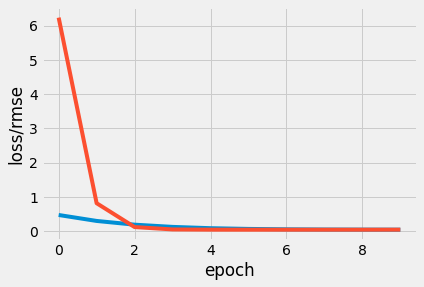

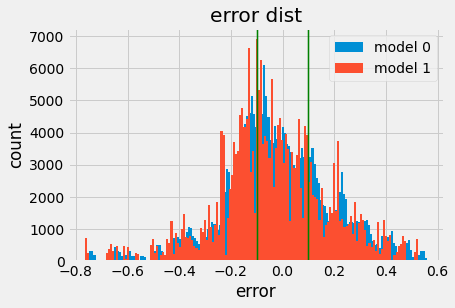

In [ ]:
for i in range(len(models)):
  eval('model '+str(i),models[i], histories[i].history)

plt.legend()
plt.show()

In [ ]:
#setup RL with a max of 10 states and defines score by increasing value of money+stockval


In [ ]:
#Ben Pygame Code (For Storage)

from turtle import width
import pygame
from pygame.locals import *

import yfinance as yf

import random

import matplotlib.pyplot as plt

import matplotlib
matplotlib.use ("Agg")

import matplotlib.backends.backend_agg as agg

import pylab

import pandas as pd

# Import Stock Codes
column_names = ["codes"]
df = pd.read_csv (r'D:\Computer Science\Personal Projects\ABCemn\StockCodes - Sheet1.csv', names = column_names)
print (df)
Stock_Codes = df.codes.to_list()
print (Stock_Codes)

# Cam Graph Code

def getData (code, period, interval) :

    try :
        df = yf.download (code, period = period, interval = interval)
        missing = list (yf.shared._ERRORS.keys ())
        print (missing)
    except Exception as e :
        print ("Couldn't download stock info :(") 
    return df
#normalize data between min max

def nextGraph () :
    stock = random.choice (Stock_Codes)
    data = getData (stock,'1mo','1h')
    curRow = 0
    batchSize = 60
    #while fix while to end when out of data
    curData = data [curRow : (curRow + batchSize)]
    #plt.plot (curData ['Close'])
    fig = pylab.figure (figsize = [8, 4], dpi = 100)
    ax = fig.gca ()
    ax.plot (curData ['Close'])
    global canvas
    canvas = agg.FigureCanvasAgg (fig)
    canvas.draw ()
    renderer = canvas.get_renderer ()
    global raw_data
    raw_data = renderer.tostring_rgb ()

# initializing the constructor
pygame.init ()
  
# screen resolution
res = (1200, 900)

# opens up a window
screen = pygame.display.set_mode(res)

#button colors

colorBuy = ("#FF312E")
colorSell = ("#20A4F3")
colorStay = ("#E2E4F6")
colorBackground = ("#6B654B")
colorBorders = ("#040403")

print ("Made Colors")

# stores the width of the
# screen into a variable
widthS = screen.get_width()
  
# stores the height of the
# screen into a variable
heightS = screen.get_height()

# defining a font
smallfont = pygame.font.SysFont('Times New Roman',35)

print ("Made Font")

# rendering a text written in
# this font
textBuy = smallfont.render ('Buy' , True , colorBorders)
textSell = smallfont.render ('Sell' , True , colorBorders)
textStay = smallfont.render ('Stay' , True , colorBorders)

textBuyDark = smallfont.render ('Buy', True, colorStay)
textSellDark = smallfont.render ('Sell', True, colorStay)
textStayDark = smallfont.render ('Stay', True, colorStay)

print ("Made Text")

count = 0

print ("Start Game")
print ("\n----------------------------------------------------\n")

run = True

nextGraph ()

while run :
    
    for ev in pygame.event.get () :

        # fills the screen with a color
        screen.fill (colorBackground)
        
        # Quit Condition
        if ev.type == pygame.QUIT :
            print ("\n----------------------------------------------------\n")
            print ("Transactions Complete. Goodbye Now.\n")
            run = False
            pygame.quit ()
            break

        # Quit After Five
        if count == 5 :
            print ("\n----------------------------------------------------\n")
            print ("Transactions Complete. Goodbye Now.\n")
            run = False
            pygame.quit ()
            break


        # Quit Button
        if ev.type == pygame.MOUSEBUTTONDOWN :
            if widthS / 32 <= mouse [0] <= widthS / 32 + 50 and heightS / 32 <= mouse [1] <= heightS / 32 + 50 :
                print ("quit")
                run = False
                pygame.quit ()
                break


        # Stay Event
        if ev.type == pygame.MOUSEBUTTONDOWN :
            if widthS / 2 - 50 <= mouse [0] <= widthS / 2 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
                print ("Stay")
                nextGraph ()
                count += 1

        # Sell Event
        if ev.type == pygame.MOUSEBUTTONDOWN :
            if widthS / 4 - 50 <= mouse [0] <= widthS / 4 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
                print ("Sell Stocks")
                nextGraph ()
                count += 1

        # Buy Event
        if ev.type == pygame.MOUSEBUTTONDOWN :
            if widthS * .75 - 50 <= mouse [0] <= widthS * .75 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
                print ("Buy Stocks")
                nextGraph ()
                count += 1
       
        # stores the (x,y) coordinates into
        # the variable as a tupl
        mouse = pygame.mouse.get_pos ()

        # Quit Button
        if widthS / 32 <= mouse [0] <= widthS / 32 + 50 and heightS / 32 <= mouse [1] <= heightS / 32 + 50 :
            pygame.draw.rect (screen, colorStay, [widthS / 32, heightS / 32, 50, 50])
            
        else :
            pygame.draw.rect (screen, colorBorders, [widthS / 32, heightS / 32, 50, 50])

        # Sell Button
        if widthS / 4 - 50 <= mouse [0] <= widthS / 4 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
            pygame.draw.rect (screen, colorBorders, [widthS / 4 - 50, heightS * .9, 100, 40])
            screen.blit (textSellDark, (widthS / 4 - 25, heightS * .9))
            
        else :
            pygame.draw.rect (screen, colorSell, [widthS / 4 - 50, heightS * .9, 100, 40])  
            screen.blit (textSell , (widthS / 4 - 25, heightS * .9))

        # Stay Button
        if widthS / 2 - 50 <= mouse [0] <= widthS / 2 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
            pygame.draw.rect (screen, colorBorders, [widthS / 2 - 50, heightS * .9, 100, 40])
            screen.blit (textStayDark, (widthS / 2 - 25, heightS * .9))
            
        else :
            pygame.draw.rect (screen, colorStay, [widthS / 2 - 50, heightS * .9, 100, 40])
            screen.blit (textStay, (widthS / 2 - 25, heightS * .9))

        #Buy Button
        if widthS * .75 - 50 <= mouse [0] <= widthS * .75 + 50 and heightS * .9 <= mouse [1] <= heightS * .9 + 40 :
            pygame.draw.rect (screen, colorBorders, [widthS * .75 - 50, heightS * .9, 100, 40])
            screen.blit (textBuyDark, (widthS * .75 - 25, heightS * .9))        
        else :
            pygame.draw.rect (screen, colorBuy, [widthS * .75 - 50, heightS * .9, 100, 40])
            screen.blit (textBuy, (widthS * .75 - 25, heightS * .9))

        # Graph
        #window = pygame.display.set_mode ((400, 400), DOUBLEBUF)
        screen = pygame.display.get_surface ()

        size = canvas.get_width_height ()

        surf = pygame.image.fromstring (raw_data, size, "RGB")
        screen.blit (surf, ((widthS / 2) - 400, (heightS / 2) - 200))
        
        # updates the frames of the game
        pygame.display.update ()

ModuleNotFoundError: ignored